In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib

In [3]:
home = pd.read_csv("C:\\mkc\\bengaluru_house_prices.csv")
print("Dataset shape:", home.shape)
home.head()


Dataset shape: (13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:

# Check for missing values
print("\nMissing values in each column:")
print(home.isnull().sum())

# Initial data cleaning
home.dropna(inplace=True)
home = home.drop(columns=['society'])
home.reset_index(drop=True, inplace=True)
print("\nShape after initial cleaning:", home.shape)

# Process BHK (number of bedrooms)
home['bhk'] = home['size'].str.extract('(\d+)').astype(float)
print("\nUnique BHK values:", sorted(home['bhk'].unique()))


Missing values in each column:
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Shape after initial cleaning: (7496, 8)

Unique BHK values: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 11.0]


<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aydes\AppData\Local\Temp\ipykernel_18260\1891460939.py:12: SyntaxWarning: invalid escape sequence '\d'
  home['bhk'] = home['size'].str.extract('(\d+)').astype(float)


In [5]:

# Function to convert square footage to numeric
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

# Apply square footage conversion
home.total_sqft = home.total_sqft.apply(convert_sqft_to_num)
home = home[home.total_sqft.notnull()]


In [6]:
# Remove properties with unrealistic square footage per bedroom
home = home[~(home.total_sqft/home.bhk < 200)]
print("\nShape after removing unrealistic sqft/bhk:", home.shape)


Shape after removing unrealistic sqft/bhk: (7478, 9)


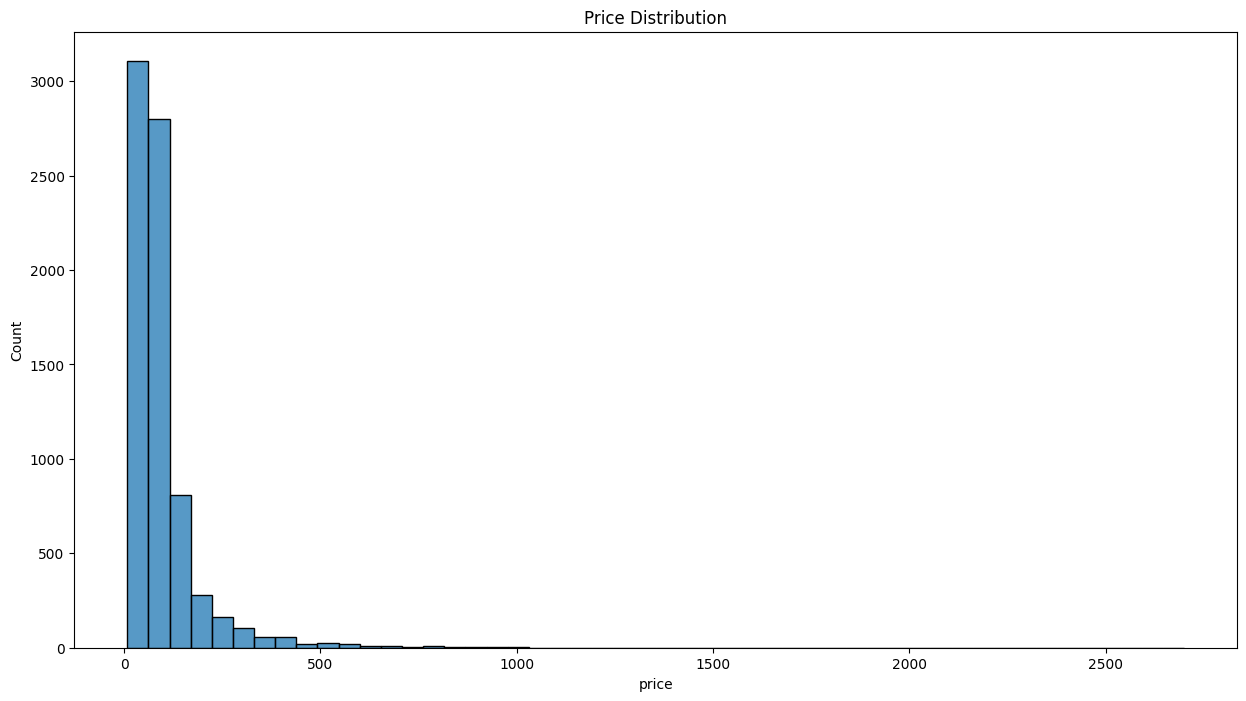

In [7]:
plt.figure(figsize=(15,8))
sns.histplot(data=home, x='price', bins=50)
plt.title('Price Distribution')
plt.show()

In [8]:
home = home.drop(home[home['bath'] > 6].index)
home = home.drop(home[home['bhk'] > 7.0].index)

# Calculate price per square foot
home['price_per_sqft'] = home['price'] * 100000 / home['total_sqft']

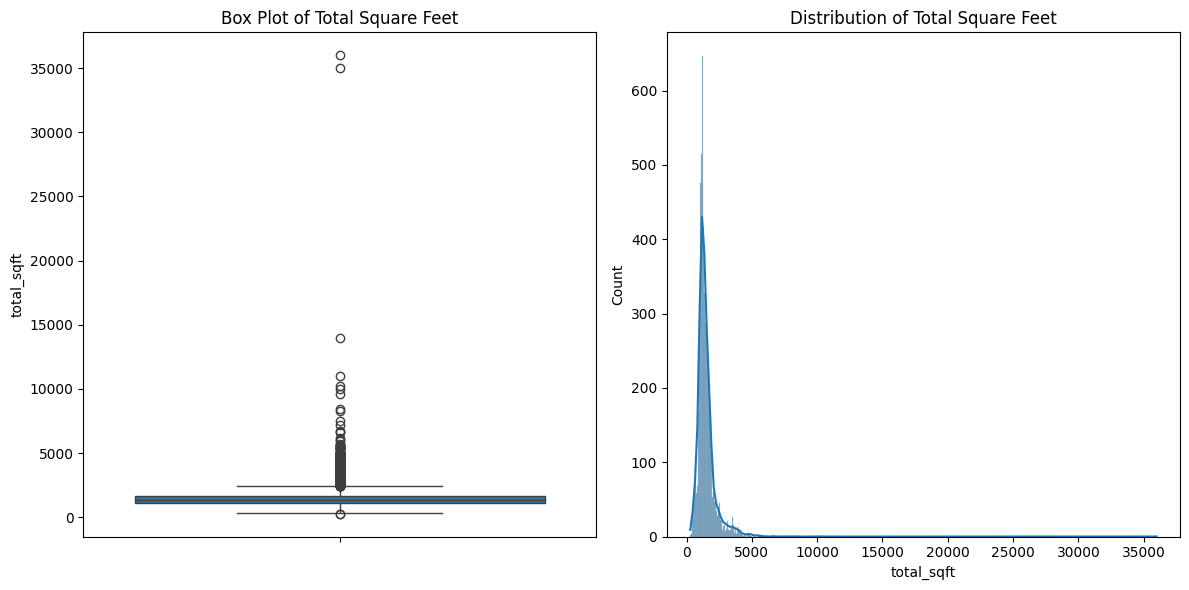

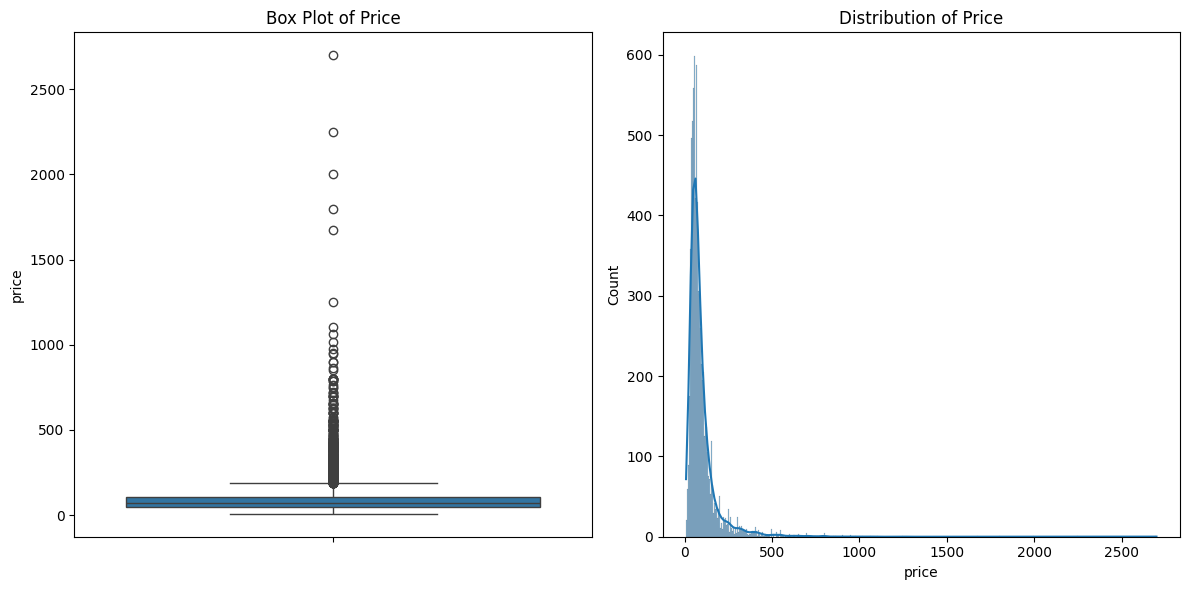

Initial shape: (7471, 10)
After Z-score outlier removal: (7077, 10)
After IQR outlier removal: (6482, 10)
After segment-based outlier removal: (6242, 10)


C:\Users\aydes\AppData\Local\Temp\ipykernel_18260\2106481713.py:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('location').apply(


After removing unrealistic combinations: (5524, 10)


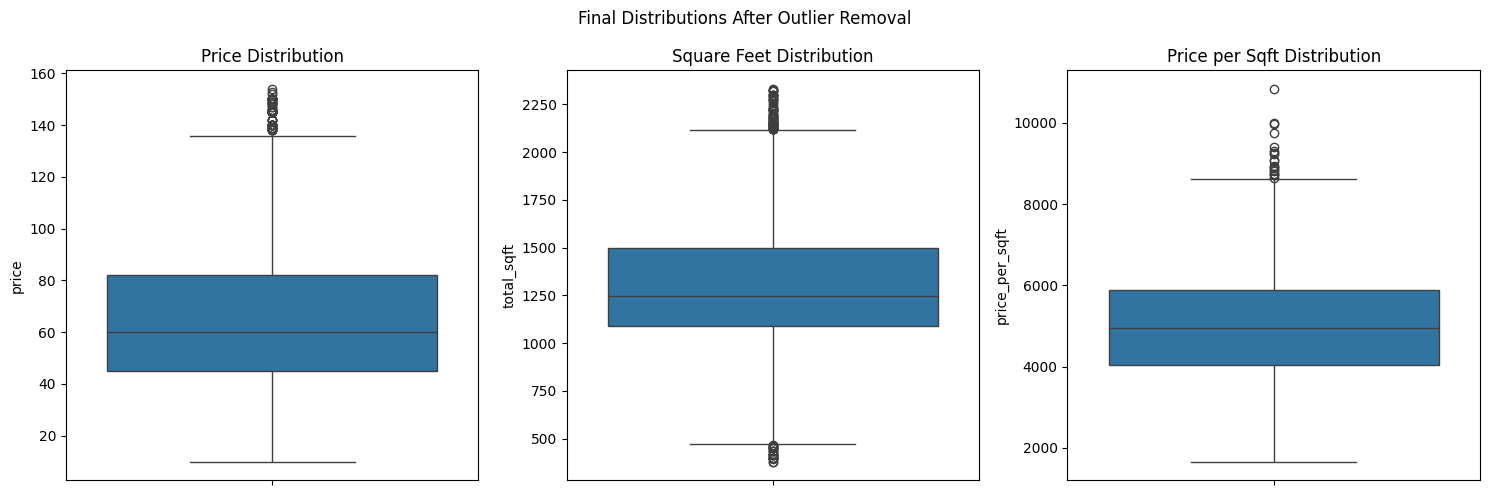

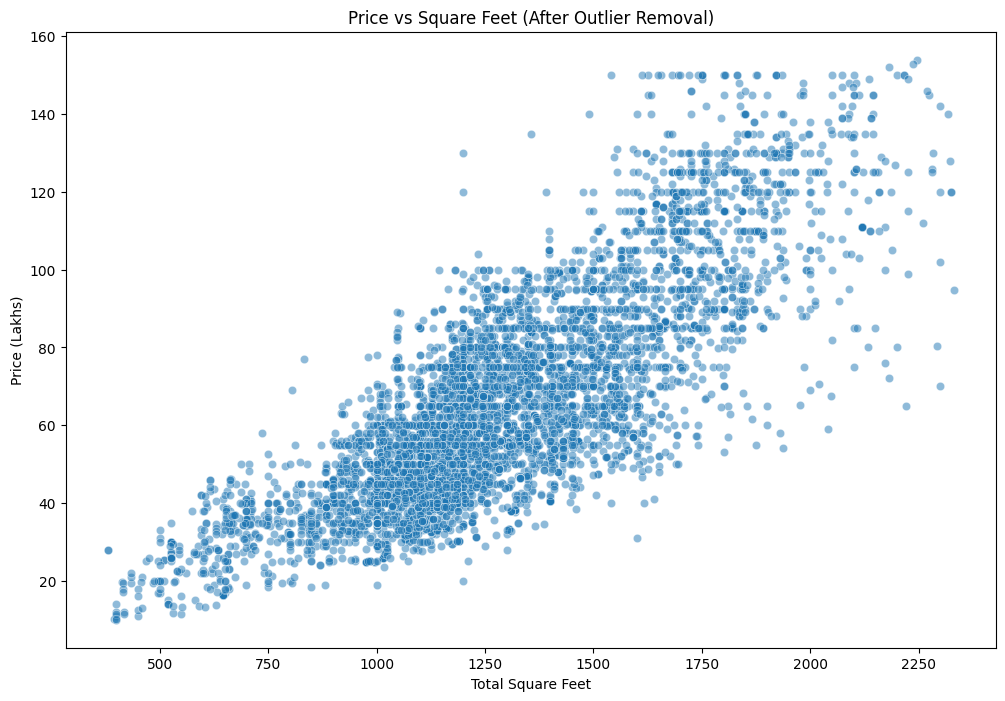

In [9]:
# Import required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from scipy import stats

# Previous data loading steps remain the same until initial cleaning
# ... [Previous code until initial cleaning]

# 1. Detect and visualize outliers in total_sqft
def plot_outliers(df, column, title):
    plt.figure(figsize=(12, 6))
    
    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box Plot of {title}')
    
    # Distribution plot
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {title}')
    plt.tight_layout()
    plt.show()

# Plot initial distributions
plot_outliers(home, 'total_sqft', 'Total Square Feet')
plot_outliers(home, 'price', 'Price')

# 2. Remove statistical outliers using Z-score for numerical columns
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Remove outliers based on Z-score method
    """
    df_clean = df.copy()
    for column in columns:
        z_scores = stats.zscore(df_clean[column])
        df_clean = df_clean[abs(z_scores) < threshold]
    return df_clean

# 3. Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    """
    Remove outliers based on IQR method
    """
    df_clean = df.copy()
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & 
                          (df_clean[column] <= upper_bound)]
    return df_clean

# 4. Function to detect price outliers by location and property size
def remove_price_outliers_by_segment(df):
    """
    Remove price outliers considering both location and property size
    """
    df_clean = df.copy()
    
    # Create size segments
    df_clean['size_segment'] = pd.qcut(df_clean['total_sqft'], q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
    
    df_out = pd.DataFrame()
    for location in df_clean['location'].unique():
        for segment in df_clean['size_segment'].unique():
            subset = df_clean[(df_clean['location'] == location) & 
                            (df_clean['size_segment'] == segment)]
            if len(subset) > 0:
                # Calculate outlier bounds for this segment
                Q1 = subset['price'].quantile(0.25)
                Q3 = subset['price'].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # Keep only non-outliers
                good_records = subset[(subset['price'] >= lower_bound) & 
                                   (subset['price'] <= upper_bound)]
                df_out = pd.concat([df_out, good_records], ignore_index=True)
    
    return df_out.drop('size_segment', axis=1)

# 5. Function to identify and remove properties with unrealistic feature combinations
def remove_unrealistic_combinations(df):
    """
    Remove properties with unrealistic combinations of features
    """
    df_clean = df.copy()
    
    # Calculate price per bhk
    df_clean['price_per_bhk'] = df_clean['price'] / df_clean['bhk']
    
    # Remove properties where:
    # 1. Price per BHK is too low or too high
    price_per_bhk_mean = df_clean['price_per_bhk'].mean()
    price_per_bhk_std = df_clean['price_per_bhk'].std()
    df_clean = df_clean[abs(df_clean['price_per_bhk'] - price_per_bhk_mean) <= 2 * price_per_bhk_std]
    
    # 2. Square feet per bathroom is unrealistic
    df_clean['sqft_per_bath'] = df_clean['total_sqft'] / df_clean['bath']
    df_clean = df_clean[df_clean['sqft_per_bath'] >= 20]  # Minimum 20 sqft per bathroom
    
    # 3. Extremely high price per sqft for the location
    df_clean = df_clean.groupby('location').apply(
        lambda x: x[x['price_per_sqft'] <= x['price_per_sqft'].quantile(0.95)]
    ).reset_index(drop=True)
    
    return df_clean.drop(['price_per_bhk', 'sqft_per_bath'], axis=1)

# Apply all outlier removal steps
print("Initial shape:", home.shape)

# 1. Remove statistical outliers using Z-score
numerical_columns = ['total_sqft', 'price', 'bhk', 'bath']
home = remove_outliers_zscore(home, numerical_columns)
print("After Z-score outlier removal:", home.shape)

# 2. Remove outliers using IQR
home = remove_outliers_iqr(home, numerical_columns)
print("After IQR outlier removal:", home.shape)

# 3. Remove price outliers by location and size segment
home = remove_price_outliers_by_segment(home)
print("After segment-based outlier removal:", home.shape)

# 4. Remove unrealistic combinations
home = remove_unrealistic_combinations(home)
print("After removing unrealistic combinations:", home.shape)

# Visualize final distributions
plt.figure(figsize=(15, 5))
plt.suptitle('Final Distributions After Outlier Removal')

plt.subplot(1, 3, 1)
sns.boxplot(data=home, y='price')
plt.title('Price Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(data=home, y='total_sqft')
plt.title('Square Feet Distribution')

plt.subplot(1, 3, 3)
sns.boxplot(data=home, y='price_per_sqft')
plt.title('Price per Sqft Distribution')

plt.tight_layout()
plt.show()

# Additional visualization: Price vs Square Feet scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=home, x='total_sqft', y='price', alpha=0.5)
plt.title('Price vs Square Feet (After Outlier Removal)')
plt.xlabel('Total Square Feet')
plt.ylabel('Price (Lakhs)')
plt.show()

In [10]:

# Drop unnecessary columns
home.drop(columns=['availability', 'size', 'area_type'], inplace=True)

# Process location data
home.location = home.location.str.strip()
location_stats = home['location'].value_counts(ascending=False)

In [11]:
# Group rare locations
location_stats_less_than_10 = location_stats[location_stats <= 10]
home.location = home.location.apply(
    lambda x: 'other' if x in location_stats_less_than_10 else x
)

# Remove 'other' locations and unrealistic bathroom counts
home = home[home.location != 'other']
home = home[home.bath < home.bhk + 2]

print("\nFinal dataset shape:", home.shape)


Final dataset shape: (4404, 7)


In [12]:

# Prepare features and target
X = home[['total_sqft', 'bath', 'bhk', 'location']]
y = home['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define preprocessing steps
numeric_features = ['total_sqft', 'bath', 'bhk']
numeric_transformer = StandardScaler()

categorical_features = ['location']
categorical_transformer = OrdinalEncoder()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create and train the full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['total_sqft', 'bath',
                                                   'bhk']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['location'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [13]:
# Evaluate the model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("\nModel Performance:")
print(f"Training R² score: {train_score:.4f}")
print(f"Testing R² score: {test_score:.4f}")



Model Performance:
Training R² score: 0.9603
Testing R² score: 0.8001


In [14]:
joblib.dump(model, 'model_pipeline.pkl')
print("\nModel and preprocessing pipeline saved!")


Model and preprocessing pipeline saved!


In [15]:
home.sample(12)

,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
3523,Marathahalli,1358.0,2.0,1.0,81.000,2.0,5964.653903
3561,Munnekollal,950.0,2.0,1.0,46.500,2.0,4894.736842
2741,Kaggadasapura,1256.0,2.0,2.0,50.000,3.0,3980.891720
2267,Horamavu Agara,994.0,2.0,1.0,42.280,2.0,4253.521127
2567,Jalahalli,1400.0,1.0,1.0,80.000,2.0,5714.285714
4196,Sarjapur Road,1586.0,3.0,3.0,70.000,3.0,4413.619168
2881,Kanakpura Road,950.0,2.0,1.0,40.000,2.0,4210.526316
4288,Sarjapur Road,1180.0,2.0,2.0,45.000,3.0,3813.559322
1399,Electronic City,2093.0,4.0,2.0,134.000,4.0,6402.293359
4292,Sarjapur Road,1112.0,2.0,1.0,62.000,2.0,5575.539568


In [16]:
home

,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
10,Electronic City,435.0,1.0,1.0,19.50,1.0,4482.758621
11,Rachenahalli,412.5,1.0,0.0,19.80,1.0,4800.000000
12,Thanisandra,510.0,1.0,0.0,25.25,1.0,4950.980392
13,Thanisandra,510.0,1.0,1.0,25.25,1.0,4950.980392
27,5th Phase JP Nagar,1075.0,2.0,2.0,60.00,2.0,5581.395349
...,...,...,...,...,...,...,...
5519,Yeshwanthpur,1385.0,2.0,2.0,76.18,3.0,5500.361011
5520,Yeshwanthpur,1381.0,2.0,2.0,76.18,3.0,5516.292542
5521,Yeshwanthpur,1384.0,2.0,2.0,76.18,3.0,5504.335260
5522,Yeshwanthpur,1500.0,3.0,1.0,100.00,3.0,6666.666667


In [17]:
max_total_sqft = home['total_sqft'].max()
print(f"Maximum total_sqft: {max_total_sqft}")

Maximum total_sqft: 2321.0


In [19]:
top_5_total_sqft = home['total_sqft'].nlargest(5)
print("Top 5 quantities in the 'total_sqft' column:")
print(top_5_total_sqft)

Top 5 quantities in the 'total_sqft' column:
5081    2321.0
5381    2317.0
212     2300.0
3687    2300.0
4414    2300.0
Name: total_sqft, dtype: float64


In [20]:
def predict_price(location, sqft, bath, bhk):
    """
    Predict house price using the trained model
    """
    input_data = pd.DataFrame({
        'location': [location],
        'total_sqft': [sqft],
        'bath': [bath],
        'bhk': [bhk]
    })
    return model.predict(input_data)[0]

# Example prediction
example_location = home['location'].iloc[0]
example_prediction = predict_price(
    location=example_location,
    sqft=550.0,
    bath=1,
    bhk=1
)
print(f"Predicted price: ₹{example_prediction:.2f} Lakhs")

Predicted price: ₹22.52 Lakhs
